In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append(os.path.abspath(os.path.join(".."))) 
import seaborn as sns
import tensorflow as tf


from src.preprocessing import create_data_generators
from src.model import create_model, train_model, save_model, load_trained_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score




In [2]:
train_dir = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\train"
test_dir = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\test"
model_path = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\chest_xray_model.h5"
img_size = (224, 224)
batch_size = 32

In [3]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(
    train_dir=train_dir,
    test_dir=test_dir,
    img_size=img_size,
    batch_size=batch_size,
    validation_split=0.2
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


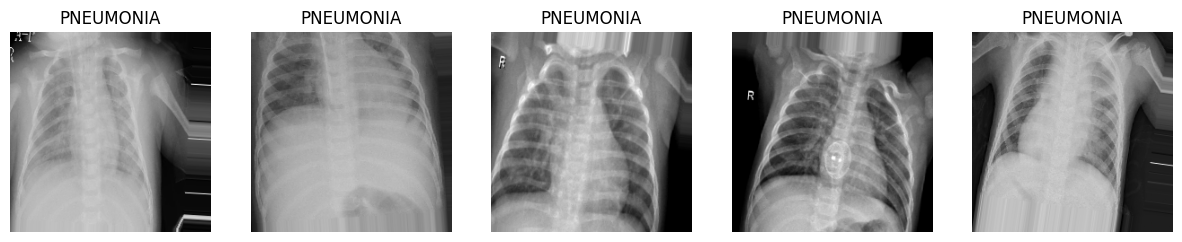

In [4]:
def plot_sample_images(generator, n=5):
    x, y = next(generator)
    plt.figure(figsize=(15, 3))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        
        # Undo VGG16 preprocessing for visualization
        img = x[i].copy()
        img[..., 0] += 103.939  # B channel
        img[..., 1] += 116.779  # G channel
        img[..., 2] += 123.68   # R channel
        img = img[..., ::-1]     # BGR -> RGB
        img = np.clip(img / 255.0, 0, 1)  # scale to [0,1] for plt.imshow
        
        plt.imshow(img)
        plt.title("PNEUMONIA" if y[i] == 1 else "NORMAL")
        plt.axis('off')
    
    plt.show()

plot_sample_images(train_gen)

In [5]:
# Create the VGG16 model
model = create_model(input_shape=(224, 224, 3), l2_factor=0.0001, dropout_rate=0.3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 12,845,568 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,628,609 (105.39 MB)

 Trainable params: 12,912,641 (49.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [6]:
# Train the model
history = train_model(
    model,
    train_generator=train_gen,
    validation_generator=val_gen,
    epochs=10,
    model_path=model_path,
    fine_tune=True
)


c:\Users\fadhl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8308 - auc: 0.9276 - loss: 0.5479 - precision: 0.9570 - recall: 0.8035 

131/131 ━━━━━━━━━━━━━━━━━━━━ 1715s 13s/step - accuracy: 0.8312 - auc: 0.9279 - loss: 0.5470 - precision: 0.9571 - recall: 0.8040 - val_accuracy: 0.9646 - val_auc: 0.9919 - val_loss: 0.2435 - val_precision: 0.9881 - val_recall: 0.9639
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9408 - auc: 0.9840 - loss: 0.3032 - precision: 0.9794 - recall: 0.9408

131/131 ━━━━━━━━━━━━━━━━━━━━ 1539s 12s/step - accuracy: 0.9408 - auc: 0.9841 - loss: 0.3032 - precision: 0.9794 - recall: 0.9408 - val_accuracy: 0.9656 - val_auc: 0.9821 - val_loss: 0.2164 - val_precision: 0.9707 - val_recall: 0.9832
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9606 - auc: 0.9918 - loss: 0.2488 - precision: 0.9875 - recall: 0.9590

131/131 ━━━━━━━━━━━━━━━━━━━━ 1555s 12s/step - accuracy: 0.9606 - auc: 0.9917 - loss: 0.2489 - precision: 0.9875 - recall: 0.9590 - val_accuracy: 0.9722 - val_auc: 0.9966 - val_loss: 0.1936 - val_precision: 0.9807 - val_recall: 0.9820
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9616 - auc: 0.9903 - loss: 0.2527 - precision: 0.9871 - recall: 0.9612

131/131 ━━━━━━━━━━━━━━━━━━━━ 1522s 12s/step - accuracy: 0.9617 - auc: 0.9903 - loss: 0.2526 - precision: 0.9871 - recall: 0.9612 - val_accuracy: 0.9837 - val_auc: 0.9979 - val_loss: 0.1700 - val_precision: 0.9884 - val_recall: 0.9897
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1524s 12s/step - accuracy: 0.9642 - auc: 0.9915 - loss: 0.2259 - precision: 0.9833 - recall: 0.9688 - val_accuracy: 0.9742 - val_auc: 0.9953 - val_loss: 0.1817 - val_precision: 0.9735 - val_recall: 0.9923
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9663 - auc: 0.9924 - loss: 0.2137 - precision: 0.9819 - recall: 0.9722

131/131 ━━━━━━━━━━━━━━━━━━━━ 1525s 12s/step - accuracy: 0.9662 - auc: 0.9923 - loss: 0.2138 - precision: 0.9819 - recall: 0.9721 - val_accuracy: 0.9809 - val_auc: 0.9981 - val_loss: 0.1652 - val_precision: 0.9859 - val_recall: 0.9884
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1518s 12s/step - accuracy: 0.9716 - auc: 0.9925 - loss: 0.2002 - precision: 0.9817 - recall: 0.9797 - val_accuracy: 0.9656 - val_auc: 0.9936 - val_loss: 0.1941 - val_precision: 0.9648 - val_recall: 0.9897
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1516s 12s/step - accuracy: 0.9697 - auc: 0.9958 - loss: 0.1892 - precision: 0.9813 - recall: 0.9776 - val_accuracy: 0.9722 - val_auc: 0.9962 - val_loss: 0.1834 - val_precision: 0.9698 - val_recall: 0.9936
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1518s 12s/step - accuracy: 0.9694 - auc: 0.9951 - loss: 0.1855 - precision: 0.9794 - recall: 0.9789 - val_accuracy: 0.9780 - val_auc: 0.9974 - val_loss: 0.1653 - val_precision: 0.9883 - val_recall: 0.9820
Starting fine-tuning...
Epoch 1

131/131 ━━━━━━━━━━━━━━━━━━━━ 1743s 13s/step - accuracy: 0.9721 - auc: 0.9946 - loss: 0.2011 - precision: 0.9855 - recall: 0.9775 - val_accuracy: 0.9837 - val_auc: 0.9976 - val_loss: 0.1592 - val_precision: 0.9948 - val_recall: 0.9832
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9831 - auc: 0.9959 - loss: 0.1652 - precision: 0.9890 - recall: 0.9881 

131/131 ━━━━━━━━━━━━━━━━━━━━ 1748s 13s/step - accuracy: 0.9830 - auc: 0.9959 - loss: 0.1652 - precision: 0.9889 - recall: 0.9881 - val_accuracy: 0.9856 - val_auc: 0.9982 - val_loss: 0.1506 - val_precision: 0.9935 - val_recall: 0.9871
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1748s 13s/step - accuracy: 0.9841 - auc: 0.9977 - loss: 0.1511 - precision: 0.9906 - recall: 0.9880 - val_accuracy: 0.9809 - val_auc: 0.9980 - val_loss: 0.1640 - val_precision: 0.9935 - val_recall: 0.9807
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 1768s 14s/step - accuracy: 0.9841 - auc: 0.9971 - loss: 0.1541 - precision: 0.9902 - recall: 0.9883 - val_accuracy: 0.9809 - val_auc: 0.9977 - val_loss: 0.1536 - val_precision: 0.9871 - val_recall: 0.9871


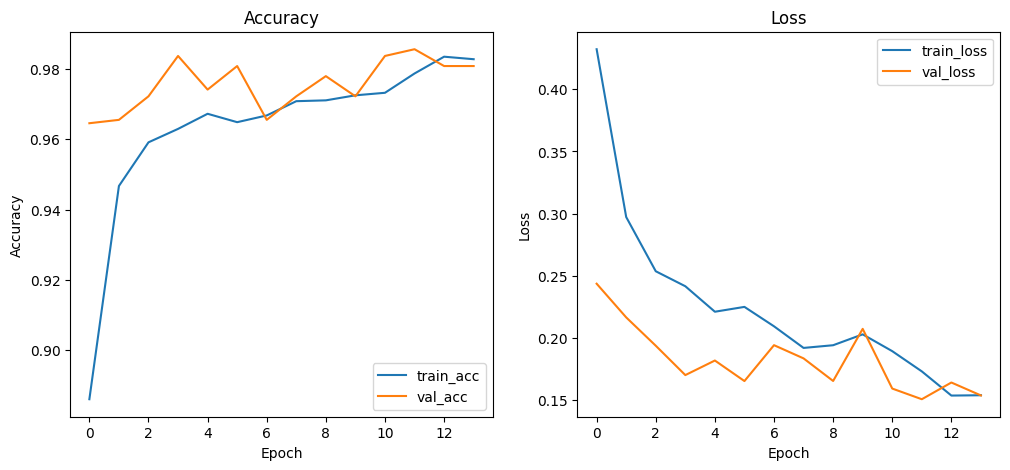

In [7]:
#Plot learning curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [9]:
print(model.metrics_names)


['loss', 'compile_metrics']


In [10]:
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_gen.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 220s 11s/step


In [11]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
loss_fn = tf.keras.losses.BinaryCrossentropy()
loss = loss_fn(y_true, y_pred_prob).numpy()

In [12]:
print("Test Loss:", loss)
print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1 Score:", f1)
print("Test AUC:", auc)

Test Loss: 0.1019898
Test Accuracy: 0.967948717948718
Test Precision: 0.9625
Test Recall: 0.9871794871794872
Test F1 Score: 0.9746835443037974
Test AUC: 0.9915844838921762


              precision    recall  f1-score   support

      NORMAL       0.98      0.94      0.96       234
   PNEUMONIA       0.96      0.99      0.97       390

    accuracy                           0.97       624
   macro avg       0.97      0.96      0.97       624
weighted avg       0.97      0.97      0.97       624



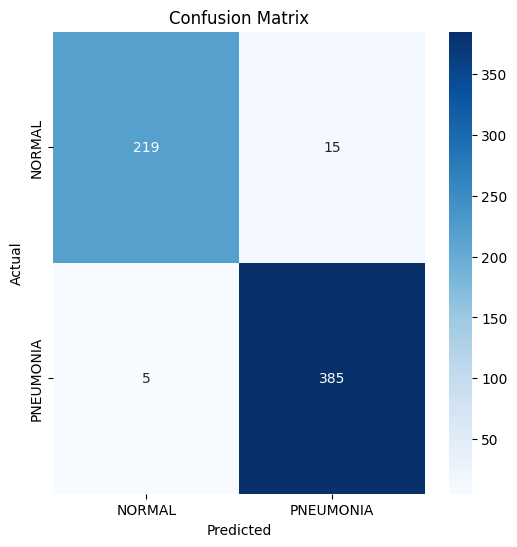

In [13]:
# Classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\chest_xray_model.h5
